<a href="https://colab.research.google.com/github/zoujiemeng/the-road-of-ML-pytorch-/blob/master/15_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

In this notebook we're going to cover the basics of computer vision using CNNs. So far we've explored using CNNs for text but their initial origin began with computer vision tasks.




<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/cnn_cv.png" width=650>

# Configuration

In [0]:
config = {
  "seed": 1234,
  "cuda": True,
  "data_url": "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/surnames.csv",
  "data_dir": "cifar10",
  "shuffle": True,
  "train_size": 0.7,
  "val_size": 0.15,
  "test_size": 0.15,
  "vectorizer_file": "vectorizer.json",
  "model_file": "model.pth",
  "save_dir": "experiments",
  "num_epochs": 5,
  "early_stopping_criteria": 5,
  "learning_rate": 1e-3,
  "batch_size": 128,
  "fc": {
    "hidden_dim": 100,
    "dropout_p": 0.1
  }
}

# Set up

In [2]:
# Load PyTorch library
!pip3 install torch

In [0]:
import os
import json
import numpy as np
import time
import torch
import uuid

### Components

In [0]:
def set_seeds(seed, cuda):
    """ Set Numpy and PyTorch seeds.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
    print ("==> 🌱 Set NumPy and PyTorch seeds.")

In [0]:
def generate_unique_id():
    """Generate a unique uuid
    preceded by a epochtime.
    """
    timestamp = int(time.time())
    unique_id = "{}_{}".format(timestamp, uuid.uuid1())
    print ("==> 🔑 Generated unique id: {0}".format(unique_id))
    return unique_id

In [0]:
def create_dirs(dirpath):
    """Creating directories.
    """
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        print ("==> 📂 Created {0}".format(dirpath))

In [0]:
def check_cuda(cuda):
    """Check to see if GPU is available.
    """
    if not torch.cuda.is_available():
        cuda = False
    device = torch.device("cuda" if cuda else "cpu")
    print ("==> 💻 Device: {0}".format(device))
    return device

### Operations

In [8]:
# Set seeds for reproducability
set_seeds(seed=config["seed"], cuda=config["cuda"])

==> 🌱 Set NumPy and PyTorch seeds.


In [9]:
# Generate unique experiment ID
config["experiment_id"] = generate_unique_id()

==> 🔑 Generated unique id: 1556180308_b47ddee2-6732-11e9-ba25-0242ac1c0002


In [10]:
# Create experiment directory
config["save_dir"] = os.path.join(config["save_dir"], config["experiment_id"])
create_dirs(dirpath=config["save_dir"])

==> 📂 Created experiments/1556180308_b47ddee2-6732-11e9-ba25-0242ac1c0002


In [11]:
# Expand file paths to store components later
config["vectorizer_file"] = os.path.join(config["save_dir"], config["vectorizer_file"])
config["model_file"] = os.path.join(config["save_dir"], config["model_file"])
print ("Expanded filepaths: ")
print ("{}".format(config["vectorizer_file"]))
print ("{}".format(config["model_file"]))

Expanded filepaths: 
experiments/1556180308_b47ddee2-6732-11e9-ba25-0242ac1c0002/vectorizer.json
experiments/1556180308_b47ddee2-6732-11e9-ba25-0242ac1c0002/model.pth


In [0]:
# Save config
config_fp = os.path.join(config["save_dir"], "config.json")
with open(config_fp, "w") as fp:
    json.dump(config, fp)

In [13]:
# Check CUDA
config["device"] = check_cuda(cuda=config["cuda"])

==> 💻 Device: cuda


# Load data

We are going to get CIFAR10 data which contains images from ten unique classes. Each image has length 32, width 32 and three color channels (RGB). We are going to save these images in a directory. Each image will have its own directory (name will be the class).

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import tensorflow as tf

### Components

In [0]:
def get_data():
    """Get CIFAR10 data.
    """
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    X = np.vstack([x_train, x_test])
    y = np.vstack([y_train, y_test]).squeeze(1)
    print ("==> 🌊 Downloading Cifar10 data using TensorFlow.")
    return X, y

In [0]:
def create_class_dirs(data_dir, classes):
    """Create class directories.
    """
    create_dirs(dirpath=data_dir)
    for _class in classes.values():
        classpath = os.path.join(data_dir, _class)
        create_dirs(dirpath=classpath)

In [0]:
def visualize_samples(data_dir, classes):
    """Visualize sample images for
    each class.
    """
    # Visualize some samples
    num_samples = len(classes)
    for i, _class in enumerate(classes.values()):  
        for file in os.listdir(os.path.join(data_dir, _class)):
            if file.endswith((".png", ".jpg", ".jpeg")):
                plt.subplot(1, num_samples, i+1)
                plt.title("{0}".format(_class))
                img = Image.open(os.path.join(data_dir, _class, file))
                plt.imshow(img)
                plt.axis("off")
                break

In [0]:
def img_to_array(fp):
    """Conver image file to NumPy array.
    """
    img = Image.open(fp)
    array = np.asarray(img, dtype="float32")
    return array

In [0]:
def load_data(data_dir, classes):
    """Load data into Pandas DataFrame.
    """
    # Load data from files
    data = []
    for i, _class in enumerate(classes.values()):  
        for file in os.listdir(os.path.join(data_dir, _class)):
            if file.endswith((".png", ".jpg", ".jpeg")):
                full_filepath = os.path.join(data_dir, _class, file)
                data.append({"image": img_to_array(full_filepath), "category": _class})
                
    # Load to Pandas DataFrame
    df = pd.DataFrame(data)
    print ("==> 🖼️ Image dimensions: {0}".format(df.image[0].shape))
    print ("==> 🍣 Raw data:")
    print (df.head())
    return df

### Operations

In [20]:
# Get CIFAR10 data
X, y = get_data()
print ("X:", X.shape)
print ("y:", y.shape)

170500096/170498071 [==============================] - 12s 0us/step
==> 🌊 Downloading Cifar10 data using TensorFlow.
X: (60000, 32, 32, 3)
y: (60000,)


In [0]:
# Classes
classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 
           6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [22]:
# Create image directories
create_class_dirs(data_dir=config["data_dir"], classes=classes)

==> 📂 Created cifar10
==> 📂 Created cifar10/plane
==> 📂 Created cifar10/car
==> 📂 Created cifar10/bird
==> 📂 Created cifar10/cat
==> 📂 Created cifar10/deer
==> 📂 Created cifar10/dog
==> 📂 Created cifar10/frog
==> 📂 Created cifar10/horse
==> 📂 Created cifar10/ship
==> 📂 Created cifar10/truck


In [0]:
# Save images for each class
for i, (image, label) in enumerate(zip(X, y)):
    _class = classes[label]
    im = Image.fromarray(image)
    im.save(os.path.join(config["data_dir"], _class, "{0:02d}.png".format(i)))

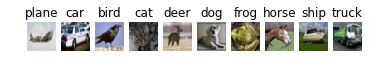

In [24]:
# Visualize each class
visualize_samples(data_dir=config["data_dir"], classes=classes)

In [25]:
# Load data into DataFrame
df = load_data(data_dir=config["data_dir"], classes=classes)

==> 🖼️ Image dimensions: (32, 32, 3)
==> 🍣 Raw data:
  category                                              image
0    plane  [[[194.0, 203.0, 214.0], [192.0, 200.0, 211.0]...
1    plane  [[[114.0, 178.0, 214.0], [113.0, 176.0, 211.0]...
2    plane  [[[229.0, 237.0, 241.0], [225.0, 231.0, 237.0]...
3    plane  [[[51.0, 80.0, 23.0], [56.0, 81.0, 31.0], [62....
4    plane  [[[121.0, 135.0, 136.0], [124.0, 138.0, 139.0]...


# Split data

Split the data into train, validation and test sets where each split has similar class distributions.

In [0]:
import collections

### Components

In [0]:
def split_data(df, shuffle, train_size, val_size, test_size):
    """Split the data into train/val/test splits.
    """
    # Split by category
    by_category = collections.defaultdict(list)
    for _, row in df.iterrows():
        by_category[row.category].append(row.to_dict())
    print ("\n==> 🛍️ Categories:")
    for category in by_category:
        print ("{0}: {1}".format(category, len(by_category[category])))

    # Create split data
    final_list = []
    for _, item_list in sorted(by_category.items()):
        if shuffle:
            np.random.shuffle(item_list)
        n = len(item_list)
        n_train = int(train_size*n)
        n_val = int(val_size*n)
        n_test = int(test_size*n)

      # Give data point a split attribute
        for item in item_list[:n_train]:
            item['split'] = 'train'
        for item in item_list[n_train:n_train+n_val]:
            item['split'] = 'val'
        for item in item_list[n_train+n_val:]:
            item['split'] = 'test'

        # Add to final list
        final_list.extend(item_list)

    # df with split datasets
    split_df = pd.DataFrame(final_list)
    print ("\n==> 🖖 Splits:")
    print (split_df["split"].value_counts())

    return split_df

### Operations

In [28]:
# Split data
split_df = split_data(
    df=df, shuffle=config["shuffle"],
    train_size=config["train_size"],
    val_size=config["val_size"],
    test_size=config["test_size"])


==> 🛍️ Categories:
plane: 6000
car: 6000
bird: 6000
cat: 6000
deer: 6000
dog: 6000
frog: 6000
horse: 6000
ship: 6000
truck: 6000

==> 🖖 Splits:
train    42000
val       9000
test      9000
Name: split, dtype: int64


# Vocabulary

Create vocabularies for the image classes.

### Components

In [0]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):

        # Token to index
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}
        
        # Add unknown token
        self.add_unk = add_unk
        self.unk_token = unk_token
        if self.add_unk:
            self.unk_index = self.add_token(self.unk_token)

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx,
                'add_unk': self.add_unk, 'unk_token': self.unk_token}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        if self.add_unk:
            index = self.token_to_idx.get(token, self.unk_index)
        else:
            index =  self.token_to_idx[token]
        return index

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

### Operations

In [30]:
# Vocabulary instance
category_vocab = Vocabulary(add_unk=False)
for index, row in df.iterrows():
    category_vocab.add_token(row.category)
print (category_vocab) # __str__
print (len(category_vocab)) # __len__
index = category_vocab.lookup_token("bird")
print (index)
print (category_vocab.lookup_index(index))

<Vocabulary(size=10)>
10
2
bird


# Sequence vocbulary

We will also create a vocabulary object for the actual images. It will store the mean and standard deviations for eahc image channel (RGB) which we will use later on for normalizing our images with the Vectorizer.

In [0]:
from collections import Counter
import string

### Components

In [0]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, train_means, train_stds):
        
        self.train_means = train_means
        self.train_stds = train_stds
        
    def to_serializable(self):
        contents = {'train_means': self.train_means,
                    'train_stds': self.train_stds}
        return contents
    
    @classmethod
    def from_dataframe(cls, df):
        train_data = df[df.split == "train"]
        means = {0:[], 1:[], 2:[]}
        stds = {0:[], 1:[], 2:[]}
        for image in train_data.image:
            for dim in range(3):
                means[dim].append(np.mean(image[:, :, dim]))
                stds[dim].append(np.std(image[:, :, dim]))
        train_means = np.array((np.mean(means[0]), np.mean(means[1]), 
                                np.mean(means[2])), dtype="float64").tolist()
        train_stds = np.array((np.mean(stds[0]), np.mean(stds[1]), 
                               np.mean(stds[2])), dtype="float64").tolist()
            
        return cls(train_means, train_stds)
        
    def __str__(self):
        return "<SequenceVocabulary(train_means: {0}, train_stds: {1}>".format(
            self.train_means, self.train_stds)

### Operations

In [33]:
# Create SequenceVocabulary instance
image_vocab = SequenceVocabulary.from_dataframe(split_df)
print (image_vocab) # __str__

<SequenceVocabulary(train_means: [125.29450225830078, 123.04263305664062, 114.05098724365234], train_stds: [51.52751922607422, 50.808067321777344, 51.19036865234375]>


# Vectorizer

The vectorizer will normalize our images using the vocabulary.

### Components

In [0]:
class ImageVectorizer(object):
    def __init__(self, image_vocab, category_vocab):
        self.image_vocab = image_vocab
        self.category_vocab = category_vocab

    def vectorize(self, image):
        # Avoid modifying the actual df
        image = np.copy(image)
        
        # Normalize
        for dim in range(3):
            mean = self.image_vocab.train_means[dim]
            std = self.image_vocab.train_stds[dim]
            image[:, :, dim] = ((image[:, :, dim] - mean) / std)
            
        # Reshape from (32, 32, 3) to (3, 32, 32)
        image = np.swapaxes(image, 0, 2)
        image = np.swapaxes(image, 1, 2)
                
        return image
    
    @classmethod
    def from_dataframe(cls, df):
        # Create vocabularies
        image_vocab = SequenceVocabulary.from_dataframe(df)
        category_vocab = Vocabulary(add_unk=False)   
        for category in sorted(set(df.category)):
            category_vocab.add_token(category)
        return cls(image_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        image_vocab = SequenceVocabulary.from_serializable(contents['image_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['category_vocab'])
        return cls(image_vocab=image_vocab, 
                   category_vocab=category_vocab)
    
    def to_serializable(self):
        return {'image_vocab': self.image_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

### Operations

In [35]:
# Vectorizer instance
vectorizer = ImageVectorizer.from_dataframe(split_df)
print (vectorizer.image_vocab)
print (vectorizer.category_vocab)
print (vectorizer.category_vocab.token_to_idx)
image_vector = vectorizer.vectorize(split_df.iloc[0].image)
print (image_vector.shape)

<SequenceVocabulary(train_means: [125.29450225830078, 123.04263305664062, 114.05098724365234], train_stds: [51.52751922607422, 50.808067321777344, 51.19036865234375]>
<Vocabulary(size=10)>
{'bird': 0, 'car': 1, 'cat': 2, 'deer': 3, 'dog': 4, 'frog': 5, 'horse': 6, 'plane': 7, 'ship': 8, 'truck': 9}
(3, 32, 32)


# Dataset

The Dataset will create vectorized data from the data.

In [0]:
import random
from torch.utils.data import Dataset, DataLoader

### Components

In [0]:
class ImageDataset(Dataset):
    def __init__(self, df, vectorizer, infer=False):
        self.df = df
        self.vectorizer = vectorizer
        
        # Data splits
        if not infer:
            self.train_df = self.df[self.df.split=='train']
            self.train_size = len(self.train_df)
            self.val_df = self.df[self.df.split=='val']
            self.val_size = len(self.val_df)
            self.test_df = self.df[self.df.split=='test']
            self.test_size = len(self.test_df)
            self.lookup_dict = {'train': (self.train_df, self.train_size), 
                                'val': (self.val_df, self.val_size),
                                'test': (self.test_df, self.test_size)}
            self.set_split('train')

            # Class weights (for imbalances)
            class_counts = df.category.value_counts().to_dict()
            def sort_key(item):
                return self.vectorizer.category_vocab.lookup_token(item[0])
            sorted_counts = sorted(class_counts.items(), key=sort_key)
            frequencies = [count for _, count in sorted_counts]
            self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        elif infer:
            self.infer_df = self.df[self.df.split=="infer"]
            self.infer_size = len(self.infer_df)
            self.lookup_dict = {'infer': (self.infer_df, self.infer_size)}
            self.set_split('infer')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, df):
        train_df = df[df.split=='train']
        return cls(df, ImageVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, df, vectorizer_filepath):
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return ImageVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        image_vector = self.vectorizer.vectorize(row.image)
        category_index = self.vectorizer.category_vocab.lookup_token(row.category)
        return {'image': image_vector, 
                'category': category_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, shuffle=True, drop_last=True, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size, 
                                shuffle=shuffle, drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [0]:
def sample(dataset):
    """Some sanity checks on the dataset.
    """
    sample_idx = random.randint(0,len(dataset))
    sample = dataset[sample_idx]
    print ("\n==> 🔢 Dataset:")
    print ("Random sample: {0}".format(sample))
    print ("Unvectorized category: {0}".format(
        dataset.vectorizer.category_vocab.lookup_index(sample['category'])))

### Operations

In [39]:
# Load dataset and vectorizer
dataset = ImageDataset.load_dataset_and_make_vectorizer(split_df)
dataset.save_vectorizer(config["vectorizer_file"])
vectorizer = dataset.vectorizer
print (dataset.class_weights)

tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002])


In [40]:
# Sample checks
sample(dataset=dataset)


==> 🔢 Dataset:
Random sample: {'image': array([[[-1.9658331e+00, -1.2477702e+00,  9.4523275e-01, ...,
          9.6463984e-01,  1.3527819e+00,  9.8404694e-01],
        [-1.9464260e+00, -1.2671773e+00,  8.8701141e-01, ...,
          1.0810825e+00,  1.4110032e+00,  9.2582566e-01],
        [-1.9270189e+00, -1.2865844e+00,  8.6760432e-01, ...,
          1.1975251e+00,  1.4886317e+00,  9.0641850e-01],
        ...,
        [-1.2215807e-01,  7.1912989e-02,  2.2716983e-01, ...,
          2.6598403e-01, -2.5122542e-02, -3.1622913e-01],
        [-2.3860070e-01, -2.5122542e-02,  2.4657694e-01, ...,
          3.6301956e-01,  1.1072720e-01, -2.7741492e-01],
        [-2.1919359e-01,  1.3691669e-02,  3.2420537e-01, ...,
          2.8539115e-01,  1.3691669e-02, -2.5800779e-01]],

       [[-1.7918932e+00, -1.3785731e+00, -8.3910016e-04, ...,
         -2.0521013e-02,  2.1566196e-01,  1.8842814e-02],
        [-1.7328476e+00, -1.3785731e+00, -4.0202927e-02, ...,
          7.7888556e-02,  2.7470770e-01,  

# Model

Basic CNN architecture for image classification.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

### Components

In [0]:
class ImageModel(nn.Module):
    def __init__(self, num_hidden_units, num_classes, dropout_p):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # input_channels:3, output_channels:10 (aka num filters)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.conv_dropout = nn.Dropout2d(dropout_p)
        self.fc1 = nn.Linear(20*5*5, num_hidden_units)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(num_hidden_units, num_classes)

    def forward(self, x, apply_softmax=False):
        # Conv pool
        z = self.conv1(x) # (N, 10, 28, 28)
        z = F.max_pool2d(z, 2) # (N, 10, 14, 14)
        z = F.relu(z)
        
        # Conv pool
        z = self.conv2(z) # (N, 20, 10, 10)
        z = self.conv_dropout(z) 
        z = F.max_pool2d(z, 2) # (N, 20, 5, 5)
        z = F.relu(z)
        
        # Flatten
        z = z.view(-1, 20*5*5)
        
        # FC
        z = F.relu(self.fc1(z))
        z = self.dropout(z)
        y_pred = self.fc2(z)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred 

In [0]:
def initialize_model(config, vectorizer):
    """Initialize the model.
    """
    print ("\n==> 🚀 Initializing model:")
    model = ImageModel(
       num_hidden_units=config["fc"]["hidden_dim"], 
       num_classes=len(vectorizer.category_vocab),
       dropout_p=config["fc"]["dropout_p"])
    print (model.named_modules)
    return model

### Operations

In [44]:
# Initializing model
model = initialize_model(config=config, vectorizer=vectorizer)


==> 🚀 Initializing model:
<bound method Module.named_modules of ImageModel(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv_dropout): Dropout2d(p=0.1)
  (fc1): Linear(in_features=500, out_features=100, bias=True)
  (dropout): Dropout(p=0.1)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)>


# Training

Training operations for image classification.

In [0]:
import torch.optim as optim

### Components

In [0]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [0]:
def update_train_state(model, train_state):
    """ Update train state during training.
    """
    # Verbose
    print ("[EPOCH]: {0} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
      train_state['epoch_index'], train_state['learning_rate'], 
        train_state['train_loss'][-1], train_state['train_acc'][-1], 
        train_state['val_loss'][-1], train_state['val_acc'][-1]))

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1

        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = train_state['early_stopping_step'] \
          >= train_state['early_stopping_criteria']
    return train_state

In [0]:
class Trainer(object):
    def __init__(self, dataset, model, model_file, device, shuffle, 
               num_epochs, batch_size, learning_rate, early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'done_training': False,
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_file}
  
    def run_train_loop(self):
        print ("==> 🏋 Training:")
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # Iterate over train dataset

            # initialize batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, 
                device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # zero the gradients
                self.optimizer.zero_grad()

                # compute the output
                y_pred = self.model(batch_dict['image'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute gradients using loss
                loss.backward()

                # use optimizer to take a gradient step
                self.optimizer.step()
                
                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # initialize batch generator, set loss and acc to 0; set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  self.model(batch_dict['image'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = update_train_state(model=self.model, train_state=self.train_state)
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        # initialize batch generator, set loss and acc to 0; set eval mode on
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['image'])

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['category'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['category'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
        
        # Verbose
        print ("==> 💯 Test performance:")
        print ("Test loss: {0:.2f}".format(self.train_state['test_loss']))
        print ("Test Accuracy: {0:.1f}%".format(self.train_state['test_acc']))

In [0]:
def plot_performance(train_state, save_dir, show_plot=True):
    """ Plot loss and accuracy.
    """
    # Figure size
    plt.figure(figsize=(15,5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(train_state["train_loss"], label="train")
    plt.plot(train_state["val_loss"], label="val")
    plt.legend(loc='upper right')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(train_state["train_acc"], label="train")
    plt.plot(train_state["val_acc"], label="val")
    plt.legend(loc='lower right')

    # Save figure
    plt.savefig(os.path.join(save_dir, "performance.png"))

    # Show plots
    if show_plot:
        print ("==> 📈 Metric plots:")
        plt.show()

In [0]:
def save_train_state(train_state, save_dir):
    train_state["done_training"] = True
    with open(os.path.join(save_dir, "train_state.json"), "w") as fp:
        json.dump(train_state, fp)
    print ("==> ✅ Training complete!")

### Operations

In [51]:
# Training
trainer = Trainer(
    dataset=dataset, model=model, model_file=config["model_file"],
    device=config["device"], shuffle=config["shuffle"], 
    num_epochs=config["num_epochs"], batch_size=config["batch_size"], 
    learning_rate=config["learning_rate"], 
    early_stopping_criteria=config["early_stopping_criteria"])
trainer.run_train_loop()

==> 🏋 Training:
[EPOCH]: 0 | [LR]: 0.001 | [TRAIN LOSS]: 1.68 | [TRAIN ACC]: 38.8% | [VAL LOSS]: 1.45 | [VAL ACC]: 47.3%
[EPOCH]: 1 | [LR]: 0.001 | [TRAIN LOSS]: 1.38 | [TRAIN ACC]: 50.7% | [VAL LOSS]: 1.30 | [VAL ACC]: 53.3%
[EPOCH]: 2 | [LR]: 0.001 | [TRAIN LOSS]: 1.26 | [TRAIN ACC]: 55.4% | [VAL LOSS]: 1.19 | [VAL ACC]: 58.3%
[EPOCH]: 3 | [LR]: 0.001 | [TRAIN LOSS]: 1.18 | [TRAIN ACC]: 58.2% | [VAL LOSS]: 1.13 | [VAL ACC]: 60.2%
[EPOCH]: 4 | [LR]: 0.001 | [TRAIN LOSS]: 1.12 | [TRAIN ACC]: 60.4% | [VAL LOSS]: 1.10 | [VAL ACC]: 60.6%


==> 📈 Metric plots:


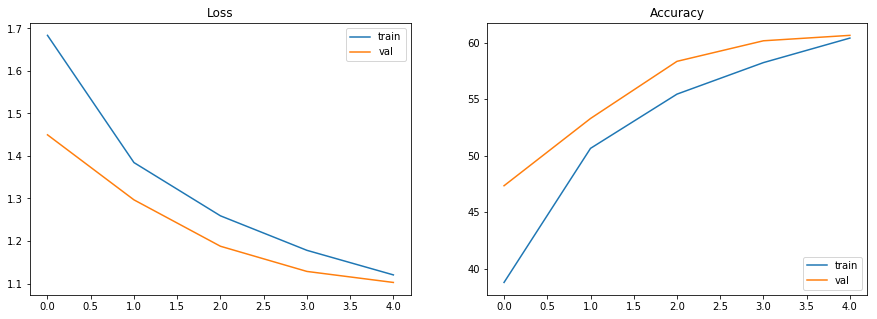

In [52]:
# Plot performance
plot_performance(train_state=trainer.train_state, 
                 save_dir=config["save_dir"], show_plot=True)

In [53]:
# Test performance
trainer.run_test_loop()

==> 💯 Test performance:
Test loss: 1.08
Test Accuracy: 62.4%


In [54]:
# Save all results
save_train_state(train_state=trainer.train_state, save_dir=config["save_dir"])

==> ✅ Training complete!


~60% test performance for our CIFAR10 dataset is not bad but we can do way better.

# Transfer learning

In this section, we're going to use a pretrained model that performs very well on a different dataset. We're going to take the architecture and the initial convolutional weights from the model to use on our data. We will freeze the initial convolutional weights and fine tune the later convolutional and fully-connected layers. 

Transfer learning works here because the initial convolution layers act as excellent feature extractors for common spatial features that are shared across images regardless of their class. We're going to leverage these large, pretrained models' feature extractors for our own dataset.

In [55]:
!pip install torchvision

In [0]:
from torchvision import models

In [57]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))
print (model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [58]:
model_name = 'vgg19_bn'
vgg_19bn = models.__dict__[model_name](pretrained=True) # Set false to train from scratch
print (vgg_19bn.named_parameters)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.torch/models/vgg19_bn-c79401a0.pth
574769405it [00:07, 76584011.40it/s]


<bound method Module.named_parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

The VGG model we chose has a `features` and a `classifier` component. The `features` component is composed of convolution and pooling layers which act as feature extractors. The `classifier` component is composed on fully connected layers. We're going to freeze most of the `feature` component and design our own FC layers for our CIFAR10 task. You can access the default code for all models at `/usr/local/lib/python3.6/dist-packages/torchvision/models` if you prefer cloning and modifying that instead.

### Components

In [0]:
class ImageModel(nn.Module):
    def __init__(self, feature_extractor, num_hidden_units, 
                 num_classes, dropout_p):
        super(ImageModel, self).__init__()
        
        # Pretrained feature extractor
        self.feature_extractor = feature_extractor
        
        # FC weights
        self.classifier = nn.Sequential(
            nn.Linear(512, 250, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(250, 100, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 10, bias=True),
            )

    def forward(self, x, apply_softmax=False):
          
        # Feature extractor
        z = self.feature_extractor(x)
        z = z.view(x.size(0), -1)
        
        # FC
        y_pred = self.classifier(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred 

In [0]:
def initialize_model(config, vectorizer, feature_extractor):
    """Initialize the model.
    """
    print ("\n==> 🚀 Initializing model:")
    model = ImageModel(
       feature_extractor=feature_extractor,
       num_hidden_units=config["fc"]["hidden_dim"], 
       num_classes=len(vectorizer.category_vocab),
       dropout_p=config["fc"]["dropout_p"])
    print (model.named_modules)
    return model

### Operations

In [61]:
# Initializing model
model = initialize_model(config=config, vectorizer=vectorizer, 
                         feature_extractor=vgg_19bn.features)


==> 🚀 Initializing model:
<bound method Module.named_modules of ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padd

In [0]:
# Finetune last few conv layers and FC layers
for i, param in enumerate(model.feature_extractor.parameters()):
    if i < 36:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [63]:
# Training
trainer = Trainer(
    dataset=dataset, model=model, model_file=config["model_file"],
    device=config["device"], shuffle=config["shuffle"], 
    num_epochs=config["num_epochs"], batch_size=config["batch_size"], 
    learning_rate=config["learning_rate"], 
    early_stopping_criteria=config["early_stopping_criteria"])
trainer.run_train_loop()

==> 🏋 Training:
[EPOCH]: 0 | [LR]: 0.001 | [TRAIN LOSS]: 0.96 | [TRAIN ACC]: 70.2% | [VAL LOSS]: 0.62 | [VAL ACC]: 80.7%
[EPOCH]: 1 | [LR]: 0.001 | [TRAIN LOSS]: 0.58 | [TRAIN ACC]: 83.0% | [VAL LOSS]: 0.54 | [VAL ACC]: 82.8%
[EPOCH]: 2 | [LR]: 0.001 | [TRAIN LOSS]: 0.43 | [TRAIN ACC]: 87.5% | [VAL LOSS]: 0.56 | [VAL ACC]: 83.6%
[EPOCH]: 3 | [LR]: 0.001 | [TRAIN LOSS]: 0.32 | [TRAIN ACC]: 90.4% | [VAL LOSS]: 0.56 | [VAL ACC]: 83.7%
[EPOCH]: 4 | [LR]: 0.001 | [TRAIN LOSS]: 0.18 | [TRAIN ACC]: 94.8% | [VAL LOSS]: 0.53 | [VAL ACC]: 86.2%


==> 📈 Metric plots:


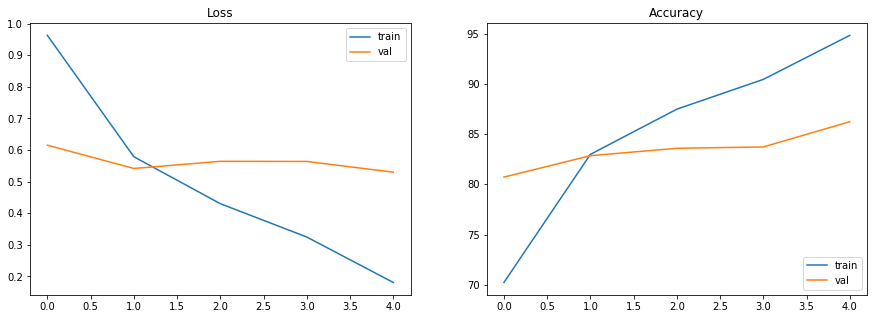

In [64]:
# Plot performance
plot_performance(train_state=trainer.train_state, 
                 save_dir=config["save_dir"], show_plot=True)

In [65]:
# Test performance
trainer.run_test_loop()

==> 💯 Test performance:
Test loss: 0.50
Test Accuracy: 86.9%


In [66]:
# Save all results
save_train_state(train_state=trainer.train_state, save_dir=config["save_dir"])

==> ✅ Training complete!


Much better performance! If you let it train long enough, we'll actually reach ~95% accuracy :)

## Inference

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 2, 2

### Components

In [0]:
class Inference(object):
    def __init__(self, model, vectorizer, device="cpu"):
        self.model = model.to(device)
        self.vectorizer = vectorizer
        self.device = device
  
    def predict_category(self, dataset):
        # Batch generator
        batch_generator = dataset.generate_batches(
            batch_size=len(dataset), shuffle=False, device=self.device)
        self.model.eval()
        
        # Predict
        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['image'], apply_softmax=True)

            # Top k categories
            y_prob, indices = torch.topk(y_pred, k=len(self.vectorizer.category_vocab))
            probabilities = y_prob.detach().to('cpu').numpy()[0]
            indices = indices.detach().to('cpu').numpy()[0]

            results = []
            for probability, index in zip(probabilities, indices):
                category = self.vectorizer.category_vocab.lookup_index(index)
                results.append({'category': category, 'probability': probability})

        return results

### Operations

In [0]:
# Load vectorizer
with open(config["vectorizer_file"]) as fp:
    vectorizer = ImageVectorizer.from_serializable(json.load(fp))

In [70]:
# Load the model
model = initialize_model(config=config, vectorizer=vectorizer, feature_extractor=vgg_19bn.features)
model.load_state_dict(torch.load(config["model_file"]))


==> 🚀 Initializing model:
<bound method Module.named_modules of ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padd

In [0]:
# Initialize
inference = Inference(model=model, vectorizer=vectorizer, device=config["device"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: bird


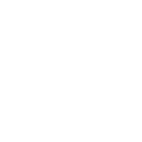

In [72]:
# Get a sample
sample = split_df[split_df.split=="test"].iloc[0]
plt.imshow(sample.image)
plt.axis("off")
print ("Actual:", sample.category)

In [73]:
# Inference
category = list(vectorizer.category_vocab.token_to_idx.keys())[0] # random filler category
infer_df = pd.DataFrame([[sample.image, category, "infer"]], columns=['image', 'category', 'split'])
infer_dataset = ImageDataset(df=infer_df, vectorizer=vectorizer, infer=True)
results = inference.predict_category(dataset=infer_dataset)
results

[{'category': 'bird', 'probability': 0.8184995},
 {'category': 'cat', 'probability': 0.10784752},
 {'category': 'plane', 'probability': 0.027508354},
 {'category': 'frog', 'probability': 0.027176514},
 {'category': 'deer', 'probability': 0.009407063},
 {'category': 'dog', 'probability': 0.007851976},
 {'category': 'horse', 'probability': 0.0007745522},
 {'category': 'ship', 'probability': 0.00068614155},
 {'category': 'truck', 'probability': 0.00016465849},
 {'category': 'car', 'probability': 8.3605286e-05}]

# TODO

- segmentation
- interpretability via activation maps
- processing images of different sizes